In [1]:
import os
import os.path as path
import sys

wk_dir = os.path.dirname(os.path.realpath('__file__'))
parent_code_dir =  path.abspath(path.join(wk_dir ,"../.."))
sys.path.append(parent_code_dir)

import logging
import random
import cv2
import math
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw


from MaskRCNN.building_blocks import utils
from MaskRCNN.config import config
from MaskRCNN.shapes import ShapesConfig, Dataset

%matplotllib inline

## Get/Prepare Data:
------

In [2]:
# Debugg
from MaskRCNN.building_blocks.data_processor import PreprareTrainData
conf = ShapesConfig()

batch_size = 1
# Get data from for randomly generated shapes
data = Dataset(num_images=batch_size, height=128, width=128)
print ('Batch Meta: ', data.image_meta)
image_ids = data.image_meta.keys()

obj_ptd = PreprareTrainData(conf, data)
data_dict = obj_ptd.get_data(image_ids)
print(data_dict.keys())


##### GET DATA TO VIZUALIZE
run_for_batch_num = 0
# Get Batch Image
batch_images = data_dict['batch_images']

# Get Image meta
batch_image_metas = data_dict['batch_image_metas']

# Get ground truth boxes
batch_gt_bboxes = data_dict['batch_gt_bboxes']

# Get ground truth boxes
batch_gt_class_id = data_dict['batch_gt_class_ids']

# Get ground truth boxes
batch_gt_masks = data_dict['batch_gt_masks']

# Get Batch RPN Target Class
batch_rpn_target_class = data_dict['batch_rpn_target_class']

# Get Boxes with iou > 0.7 to gt_boxes: batch_rpn target box
batch_rpn_target_bbox = data_dict['batch_rpn_target_bbox']

# Get Positive anchors with IOU more than 0.7
batch_positive_anchors = data_dict['batch_positive_anchors']

[145   2  84]
4
height width:  128 128
object_  square
color ........  (96, 188, 76)
height width:  128 128
object_  circle
color ........  (24, 175, 73)
height width:  128 128
object_  square
color ........  (174, 73, 155)
height width:  128 128
object_  square
color ........  (89, 135, 139)
bounding_boxes  [[ 26  40  86 100]
 [  6  73  56 123]
 [ 52  46 112 106]
 [ 57  30  97  70]]
active_class_info ...................  [('circle', (24, 175, 73), (31, 98, 25)), ('square', (174, 73, 155), (82, 76, 30)), ('square', (89, 135, 139), (77, 50, 20))]
Batch Meta:  {0: {'height': 128, 'width': 128, 'bg_color': array([145,   2,  84]), 'active_class_info': [('circle', (24, 175, 73), (31, 98, 25)), ('square', (174, 73, 155), (82, 76, 30)), ('square', (89, 135, 139), (77, 50, 20))]}}
Anchors Max Min length:  154.509667992 -90.5096679919
Anchor shape:  (4092, 4)
Achor Area:  (4092,)
active_class_info ....................  [('circle', (24, 175, 73), (31, 98, 25)), ('square', (174, 73, 155), (82, 76

[0 1 2]


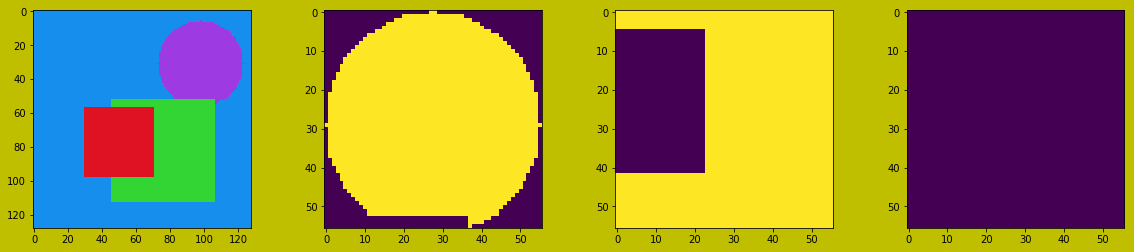

In [3]:
indice = np.where(np.sum(abs(batch_gt_bboxes), axis=2)[run_for_batch_num] != 0)[0]
print(indice)
image = batch_images[run_for_batch_num]
gt_box = batch_gt_bboxes[run_for_batch_num, indice]
gt_masks = batch_gt_masks[run_for_batch_num, :,:,indice]
anchors_idx_with_neg_iou = np.where(batch_rpn_target_class[run_for_batch_num] == -1)[0]
anchors_idx_with_neutral_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 0)[0]
anchors_idx_with_pos_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 1)[0]
rpn_target_bbox = batch_rpn_target_bbox[run_for_batch_num, indice]
positive_anchor_bbox = batch_positive_anchors[run_for_batch_num]

positive_anchors = obj_ptd.anchors[anchors_idx_with_pos_iou]
neutral_anchors = obj_ptd.anchors[anchors_idx_with_neutral_iou]
negative_anchors = obj_ptd.anchors[anchors_idx_with_neg_iou]

from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=1, cols=4, figsize=(20,4))

obj_viz.vizualize_image(image)
for j in range(0,3):  # total number of labels
    if j < gt_masks.shape[0]:
        obj_viz.vizualize_image(gt_masks[j,:,:])
    else:
        obj_viz.num += 1
obj_viz.show()

#### Batch Images:

In [4]:
print('batch_images: ', batch_images.shape, batch_images)

batch_images:  (1, 128, 128, 3) [[[[  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   ..., 
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]]

  [[  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   ..., 
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]]

  [[  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   ..., 
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -19.89999962]]

  ..., 
  [[  21.29999924 -114.80000305  -19.89999962]
   [  21.29999924 -114.80000305  -

#### Batch Image Meta:

In [5]:
print('batch_image_metas: ', batch_image_metas.shape, batch_image_metas)

batch_image_metas:  (1, 16) [[  0 128 128   3 128 128   3   0   0 128 128   1   1   1   1   1]]


#### Batch rpn Target class:

In [6]:
print('batch_rpn_target_class ', batch_rpn_target_class.shape, 
      sum(sum(batch_rpn_target_class)), 
      batch_rpn_target_class)

batch_rpn_target_class  (1, 4092, 1) [-250] [[[0]
  [0]
  [0]
  ..., 
  [0]
  [0]
  [0]]]


#### Batch rpn Box:

In [7]:
print('batch_rpn_target_bbox: ', batch_rpn_target_bbox.shape, batch_rpn_target_bbox)

batch_rpn_target_bbox:  (1, 256, 4) [[[-0.78125     0.78125     1.23918082  1.23918082]
  [-0.234375    0.390625   -1.33531393 -1.13528725]
  [-1.49155337  2.76213586 -1.97291405  1.49282186]
  ..., 
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]]


#### Batch GT classid

In [8]:
print('batch_gt_class_id: ', batch_gt_class_id.shape, batch_gt_class_id)

batch_gt_class_id:  (1, 100) [[2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


#### Batch GT Box

In [9]:
print('batch_gt_bboxes: ', batch_gt_bboxes.shape, batch_gt_bboxes)

batch_gt_bboxes:  (1, 100, 4) [[[  6  73  55 124]
  [ 52  46 113 107]
  [ 57  30  98  71]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0

#### Batach GT Mask

In [10]:
print('batch_gt_masks: ', batch_gt_masks.shape, 
      sum(sum(sum(batch_gt_masks))), batch_gt_masks)

batch_gt_masks:  (1, 56, 56, 100) [2387 2285 3136    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0] [[[[False  True  True ..., False False False]
   [False  True  True ..., False False False]
   [False  True  True ..., False False False]
   ..., 
   [False  True  True ..., False False False]
   [False  True  True ..., False False False]
   [False  True  True ..., False False False]]

  [[False  True  True ..., False False False]
   [False  True  True ..., False False False]
   [False  True  True ..., False False False]
   ..., 
   [False  True  True ..

#### Anchors:

In [11]:
# batch_gt_bboxes.shape
indice = np.where(np.sum(abs(batch_gt_bboxes), axis=2)[run_for_batch_num] != 0)[0]
print(indice)
image = batch_images[run_for_batch_num]
gt_box = batch_gt_bboxes[run_for_batch_num, indice]
gt_masks = batch_gt_masks[run_for_batch_num, :,:,indice]
anchors_idx_with_neg_iou = np.where(batch_rpn_target_class[run_for_batch_num] == -1)[0]
anchors_idx_with_neutral_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 0)[0]
anchors_idx_with_pos_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 1)[0]
rpn_target_bbox = batch_rpn_target_bbox[run_for_batch_num, indice]
positive_anchor_bbox = batch_positive_anchors[run_for_batch_num]

positive_anchors = obj_ptd.anchors[anchors_idx_with_pos_iou]
neutral_anchors = obj_ptd.anchors[anchors_idx_with_neutral_iou]
negative_anchors = obj_ptd.anchors[anchors_idx_with_neg_iou]

print ('image ', image.shape)
print ('gt_box ', gt_box.shape)
print ('gt_masks ', gt_masks.shape)
print ('rpn_target_bbox ', rpn_target_bbox.shape)

print ('anchors_idx_with_neg_iou ', len(anchors_idx_with_neg_iou))
print ('anchors_idx_with_neutral_iou ', len(anchors_idx_with_neutral_iou))
print ('anchors_idx_with_pos_iou ', len(anchors_idx_with_pos_iou))
print ('positive_anchors ', positive_anchors.shape)
print ('neutral_anchors ', neutral_anchors.shape)
print ('negative_anchors ', negative_anchors.shape)


print ('positive_anchor_bbox ', positive_anchor_bbox.shape)



[0 1 2]
image  (128, 128, 3)
gt_box  (3, 4)
gt_masks  (3, 56, 56)
rpn_target_bbox  (3, 4)
anchors_idx_with_neg_iou  253
anchors_idx_with_neutral_iou  3836
anchors_idx_with_pos_iou  3
positive_anchors  (3, 4)
neutral_anchors  (3836, 4)
negative_anchors  (253, 4)
positive_anchor_bbox  (3, 4)


In [12]:
positive_anchor_bbox

array([[  64.      ,   32.      ,   96.      ,   64.      ],
       [   0.      ,   64.      ,   64.      ,  128.      ],
       [  50.745166,   41.372583,  141.254834,   86.627417]])

#### Check if Positive index on the anchor box is the same as extracted positive_anchor_box

In [13]:
print (obj_ptd.anchors[anchors_idx_with_pos_iou])  
print (positive_anchor_bbox)

[[  64.         32.         96.         64.      ]
 [   0.         64.         64.        128.      ]
 [  50.745166   41.372583  141.254834   86.627417]]
[[  64.         32.         96.         64.      ]
 [   0.         64.         64.        128.      ]
 [  50.745166   41.372583  141.254834   86.627417]]


## Vizualize obejcts:
---------

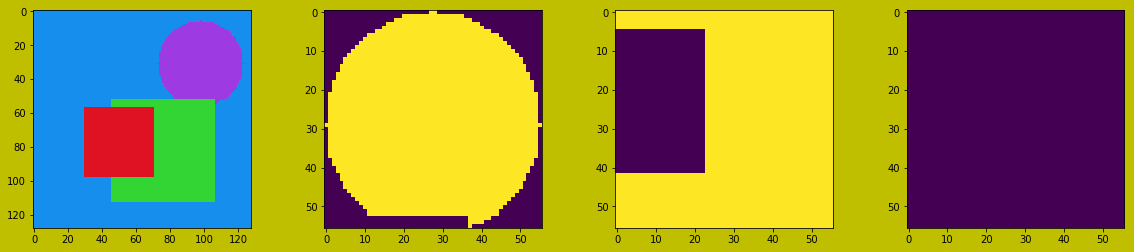

In [14]:
from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=1, cols=4, figsize=(20,4))

obj_viz.vizualize_image(image)
for j in range(0,3):  # total number of labels
    if j < gt_masks.shape[0]:
        obj_viz.vizualize_image(gt_masks[j,:,:])
    else:
        obj_viz.num += 1
obj_viz.show()

## Vizualize Ground Truth Boxes
---------

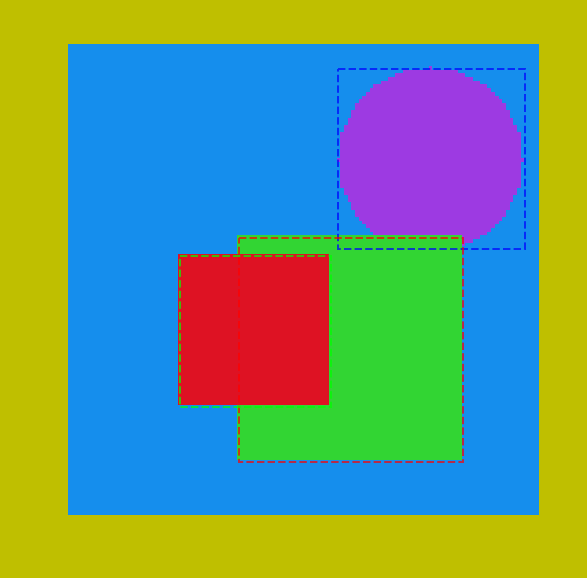

In [15]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(gt_box, image)
obj_viz.show()

## Vizualize Positive Anchors woth IOU > 0.7 or the bouding box with max IOU
------

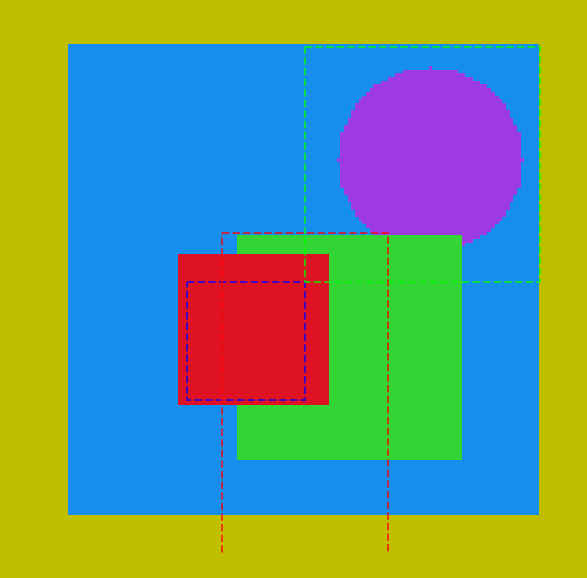

In [16]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(positive_anchor_bbox, image)
obj_viz.show()

## Vizualize Negative Anchors with IOU < 0.3
----------

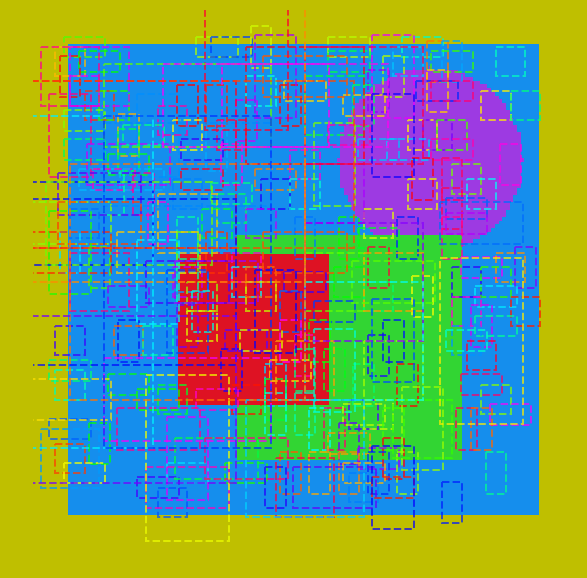

In [17]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(negative_anchors, image)
obj_viz.show()

## Vizualize Neutral Anchors 0.3<IOU<0.7

#### Read this:
* You might be wondering, why many boxes, which seem to have iou = 0 are marked as neutral. This is becasue. In normal scenario we would have a class imbalance problem, where we would end up having more negative classes than positive classes.

* Moreover, for regression Loss we have stated a limit of 256 anchors 128(+ve) and 128(-ve). in real scenario we would have -ve anchors >>> 128. Hence for training and loss calculation we select only 128 anchors from the list of all -ve anchors and make all other -ve anchors as neutral.

In [18]:
np.random.shuffle(neutral_anchors)

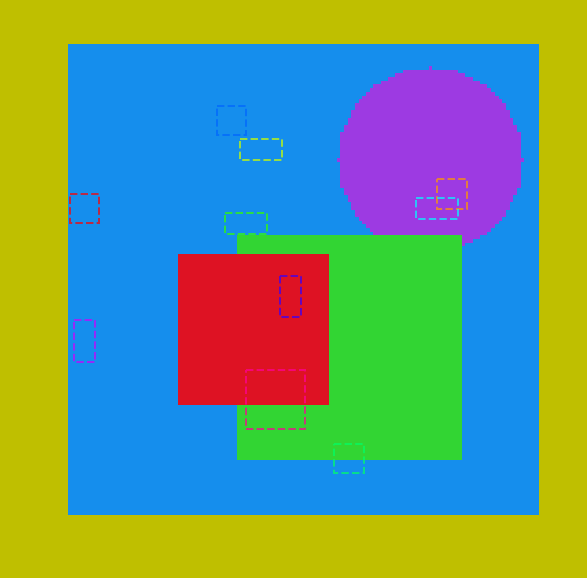

In [19]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(neutral_anchors[0:10], image)
obj_viz.show()

## Lets do some Training:
--------

In [20]:
from MaskRCNN.training import Train as Train
from MaskRCNN.training_debug import Train as TrainDebug
print(data_dict['batch_image_metas'])
pretrained_weights_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/MaskRCNN/mask_rcnn_coco.h5'

obj_trn = Train(conf, batch_size=batch_size,
                pretrained_weights_path=pretrained_weights_path)
obj_trn.exec_sess(data_dict, image_ids)


Using TensorFlow backend.


[[  0 128 128   3 128 128   3   0   0 128 128   1   1   1   1   1]]
(FPN) C2: (shape)  (?, 32, 32, 256)
(FPN) C3: (shape)  (?, 16, 16, 512)
(FPN) C4: (shape)  (?, 8, 8, 1024)
(FPN) C5: (shape)  (?, 4, 4, 2048)
(FPN) P2: (shape)  (?, 32, 32, 256)
(FPN) P3: (shape)  (?, 16, 16, 256)
(FPN) P4: (shape)  (?, 8, 8, 256)
(FPN) P5: (shape)  (?, 4, 4, 256)
(FPN) P6: (shape)  (?, 2, 2, 256)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(Proposals) Proposals (shape)  (1, ?, ?)
Proposal DEBUG ................
(MRCNN) Pooled Roi

Variable name:  <HDF5 group "/bn3a_branch1/bn3a_branch1" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch1/bn3a_branch1" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch1/bn3a_branch1" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch1/bn3a_branch1" (4 members)>
Variable name:  <HDF5 group "/res3a_branch2a/res3a_branch2a" (2 members)>
Variable name:  <HDF5 group "/res3a_branch2a/res3a_branch2a" (2 members)>
Variable name:  <HDF5 group "/bn3a_branch2a/bn3a_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch2a/bn3a_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch2a/bn3a_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch2a/bn3a_branch2a" (4 members)>
Variable name:  <HDF5 group "/res3a_branch2b/res3a_branch2b" (2 members)>
Variable name:  <HDF5 group "/res3a_branch2b/res3a_branch2b" (2 members)>
Variable name:  <HDF5 group "/bn3a_branch2b/bn3a_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn3a_branch2b/bn3a_branch2b" (4 me

Variable name:  <HDF5 group "/bn4b_branch2c/bn4b_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4b_branch2c/bn4b_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4b_branch2c/bn4b_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4b_branch2c/bn4b_branch2c" (4 members)>
Variable name:  <HDF5 group "/res4c_branch2a/res4c_branch2a" (2 members)>
Variable name:  <HDF5 group "/res4c_branch2a/res4c_branch2a" (2 members)>
Variable name:  <HDF5 group "/bn4c_branch2a/bn4c_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4c_branch2a/bn4c_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4c_branch2a/bn4c_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4c_branch2a/bn4c_branch2a" (4 members)>
Variable name:  <HDF5 group "/res4c_branch2b/res4c_branch2b" (2 members)>
Variable name:  <HDF5 group "/res4c_branch2b/res4c_branch2b" (2 members)>
Variable name:  <HDF5 group "/bn4c_branch2b/bn4c_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4c_branch2b/bn4c_branch2

Variable name:  <HDF5 group "/bn4i_branch2a/bn4i_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2a/bn4i_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2a/bn4i_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2a/bn4i_branch2a" (4 members)>
Variable name:  <HDF5 group "/res4i_branch2b/res4i_branch2b" (2 members)>
Variable name:  <HDF5 group "/res4i_branch2b/res4i_branch2b" (2 members)>
Variable name:  <HDF5 group "/bn4i_branch2b/bn4i_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2b/bn4i_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2b/bn4i_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2b/bn4i_branch2b" (4 members)>
Variable name:  <HDF5 group "/res4i_branch2c/res4i_branch2c" (2 members)>
Variable name:  <HDF5 group "/res4i_branch2c/res4i_branch2c" (2 members)>
Variable name:  <HDF5 group "/bn4i_branch2c/bn4i_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4i_branch2c/bn4i_branch2

Variable name:  <HDF5 group "/bn4o_branch2b/bn4o_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2b/bn4o_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2b/bn4o_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2b/bn4o_branch2b" (4 members)>
Variable name:  <HDF5 group "/res4o_branch2c/res4o_branch2c" (2 members)>
Variable name:  <HDF5 group "/res4o_branch2c/res4o_branch2c" (2 members)>
Variable name:  <HDF5 group "/bn4o_branch2c/bn4o_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2c/bn4o_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2c/bn4o_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4o_branch2c/bn4o_branch2c" (4 members)>
Variable name:  <HDF5 group "/res4p_branch2a/res4p_branch2a" (2 members)>
Variable name:  <HDF5 group "/res4p_branch2a/res4p_branch2a" (2 members)>
Variable name:  <HDF5 group "/bn4p_branch2a/bn4p_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4p_branch2a/bn4p_branch2

Variable name:  <HDF5 group "/bn4u_branch2c/bn4u_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4u_branch2c/bn4u_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4u_branch2c/bn4u_branch2c" (4 members)>
Variable name:  <HDF5 group "/bn4u_branch2c/bn4u_branch2c" (4 members)>
Variable name:  <HDF5 group "/res4v_branch2a/res4v_branch2a" (2 members)>
Variable name:  <HDF5 group "/res4v_branch2a/res4v_branch2a" (2 members)>
Variable name:  <HDF5 group "/bn4v_branch2a/bn4v_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4v_branch2a/bn4v_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4v_branch2a/bn4v_branch2a" (4 members)>
Variable name:  <HDF5 group "/bn4v_branch2a/bn4v_branch2a" (4 members)>
Variable name:  <HDF5 group "/res4v_branch2b/res4v_branch2b" (2 members)>
Variable name:  <HDF5 group "/res4v_branch2b/res4v_branch2b" (2 members)>
Variable name:  <HDF5 group "/bn4v_branch2b/bn4v_branch2b" (4 members)>
Variable name:  <HDF5 group "/bn4v_branch2b/bn4v_branch2

#### Ground Truth Data:
-------

In [21]:
obj_trn.batch_gt_bboxes  # batch_gt_boxes are zero_paded

array([[[  6,  73,  55, 124],
        [ 52,  46, 113, 107],
        [ 57,  30,  98,  71],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [ 

#### RPN Class:
------

In [22]:
print('(RPN) Target Class: ', obj_trn.batch_rpn_target_class)
np.where(batch_rpn_target_class[run_for_batch_num] == 1)

(RPN) Target Class:  [[[0]
  [0]
  [0]
  ..., 
  [0]
  [0]
  [0]]]


(array([3970, 4054, 4074]), array([0, 0, 0]))

In [23]:
print('(RPN) Pred Logits: ', obj_trn.outputs_[0])

(RPN) Pred Logits:  [[[ 201.4161377   221.00543213]
  [-664.92596436   -8.95970154]
  [-123.12055206 -308.67510986]
  ..., 
  [  74.4813385    39.92649841]
  [-166.98858643  -36.87721634]
  [-197.8571167  -109.42250824]]]


In [24]:
print('(RPN) Pred probs: ', obj_trn.outputs_[1])

(RPN) Pred probs:  [[[  3.10797499e-09   1.00000000e+00]
  [  0.00000000e+00   1.00000000e+00]
  [  1.00000000e+00   0.00000000e+00]
  ..., 
  [  1.00000000e+00   9.84064667e-16]
  [  0.00000000e+00   1.00000000e+00]
  [  0.00000000e+00   1.00000000e+00]]]


#### RPN Boxes:
------

In [25]:
print('(RPN) Target Bbox: ', obj_trn.batch_rpn_target_bbox)

(RPN) Target Bbox:  [[[-0.78125     0.78125     1.23918082  1.23918082]
  [-0.234375    0.390625   -1.33531393 -1.13528725]
  [-1.49155337  2.76213586 -1.97291405  1.49282186]
  ..., 
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]]


In [26]:
print('(RPN) Pred Bbox: ', obj_trn.outputs_[2])

(RPN) Pred Bbox:  [[[ -10.57090473 -451.52709961 -404.64862061  -16.98497009]
  [ 324.58416748 -210.03317261  -25.46047974  -14.76081848]
  [  96.52058411 -207.74389648  224.7641449   251.16430664]
  ..., 
  [  -7.11525917   77.90625763 -366.90869141  -37.26107025]
  [ 152.19485474   33.57973862  -99.92188263 -134.29415894]
  [ -63.37756348 -182.71760559  261.96624756  -89.91821289]]]


In [27]:
print('(Proposals) proposals rois: ', obj_trn.outputs_[3].shape, obj_trn.outputs_[3])

(Proposals) proposals rois:  (1, 2000, 4) [[[ 0.  0.  0.  0.]
  [ 1.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  ..., 
  [ 1.  0.  1.  0.]
  [ 1.  0.  1.  0.]
  [ 0.  0.  0.  0.]]]


## Debug Detection Target creation layer:

In [31]:
from MaskRCNN.building_blocks import data_processor
import tensorflow as tf
def get_detection_target_graph(proposals_, input_gt_class_ids, input_gt_boxes_pxl):
    batch_rois = []
    batch_rois_gt_class_ids = []
    batch_rois_gt_class_boxes = []
    for i in range(0, obj_trn.batch_size):
        obj_dp = data_processor.BuildDetectionTargets(
                conf, proposals_[i], input_gt_class_ids[i], input_gt_boxes_pxl[i],
                DEBUG=True)
        rois, roi_gt_class_ids, roi_gt_box_deltas = obj_dp.get_target_rois()
        debug_opt = obj_dp.debug_outputs()
        break
#         batch_rois.append(rois)
#         batch_rois_gt_class_ids.append(roi_gt_class_ids)
#         batch_rois_gt_class_boxes.append(roi_gt_box_deltas)

#         batch_rois = tf.stack(batch_rois, axis=0)
#         batch_rois_gt_class_ids = tf.concat(batch_rois_gt_class_ids, axis=0)
#         batch_rois_gt_class_boxes = tf.stack(batch_rois_gt_class_boxes, axis=0)

    return batch_rois, batch_rois_gt_class_ids, batch_rois_gt_class_boxes, debug_opt

In [32]:
# tf.reset_default_graph()
proposals_ = tf.placeholder(shape=[1,2000,4], dtype=tf.float32, name='pp')
input_gt_class_ids = tf.placeholder(dtype=tf.int32,
                                    shape=[None, None],
                                    name='icid')

rois, mrcnn_target_class_ids, mrcnn_target_box, debug_opt = get_detection_target_graph(
            proposals_,
            input_gt_class_ids,
            obj_trn.input_gt_boxes_norm
)
debug_outputs = [debug_opt['non_zero_proposals'],
                 debug_opt['prop_corresponding_gt_non_zero'],
                 debug_opt['non_zeros_gt_box'],
                    debug_opt['gt_boxes_non_zero'],
                    debug_opt['gt_class_ids_non_zero'],
                    debug_opt['iou'],
                    debug_opt['roi_iou_max'],
                    debug_opt['pos_indices_05more'],
                    debug_opt['neg_indices_05more'],
#                     debug_opt['num_pos_inst'],
                    debug_opt['pos_indices'],
                    debug_opt['pos_count'],
                    debug_opt['neg_cnt'],
                    debug_opt['neg_indices'],
                    debug_opt['pos_rois'],
                    debug_opt['neg_rois'],
                    debug_opt['pos_iou'],
                    debug_opt['roi_gt_box_assignment'],
                    debug_opt['roi_gt_class_ids'],
                    debug_opt['roi_gt_boxes'],
                    debug_opt['roi_gt_box_deltas']
                ]

feed_dict = {obj_trn.xIN: obj_trn.batch_images,
         obj_trn.anchors: obj_trn.anchors_normed,
         input_gt_class_ids: obj_trn.batch_gt_class_ids,
         obj_trn.input_gt_boxes_pxl: obj_trn.batch_gt_bboxes,
         obj_trn.rpn_target_class: obj_trn.batch_rpn_target_class,
         obj_trn.rpn_target_bbox: obj_trn.batch_rpn_target_bbox,
             proposals_:obj_trn.outputs_[3]
         }

import tensorflow as tf
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_ = sess.run(debug_outputs, feed_dict=feed_dict)
    

In [33]:
obj_trn.batch_gt_bboxes


array([[[  6,  73,  55, 124],
        [ 52,  46, 113, 107],
        [ 57,  30,  98,  71],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [ 

In [34]:
print('non_zeros_proposals: ', output_[0].shape, output_[0]),

non_zeros_proposals:  (2000,) [False  True False ...,  True  True False]


(None,)

In [35]:
print('prop_corresponding_gt_non_zero: ', output_[1].shape, output_[1]),

prop_corresponding_gt_non_zero:  (1426, 4) [[ 1.          0.          1.          0.        ]
 [ 0.51374483  0.          0.51374483  0.        ]
 [ 0.          0.          0.          1.        ]
 ..., 
 [ 0.          0.41631895  0.          0.41631895]
 [ 1.          0.          1.          0.        ]
 [ 1.          0.          1.          0.        ]]


(None,)

In [36]:
print('non_zeros_gt_box: ', output_[2].shape, output_[2]),

non_zeros_gt_box:  (100,) [ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


(None,)

In [37]:
print('gt_boxes_non_zero ', output_[3].shape, output_[3])

gt_boxes_non_zero  (3, 4) [[ 0.04724409  0.57480317  0.42519686  0.96850395]
 [ 0.40944883  0.36220473  0.88188976  0.83464569]
 [ 0.44881889  0.23622048  0.76377952  0.55118108]]


In [43]:
print('gt_class_ids_non_zero ', output_[4].shape, output_[4])

gt_class_ids_non_zero  (2,) [3 1]


In [44]:
print('iou proposal_pred Vs gt_box_norm ', output_[5].shape, output_[5])

iou proposal_pred Vs gt_box_norm  (1902, 2) [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [38]:
print (np.where(output_[5][:,0] !=0)[0])
print(np.where(output_[5][:,1] !=0)[0])
output_[5][np.where(output_[5][:,0] !=0)[0],:]

[ 340  643 1000 1089 1205]
[ 340  643 1162]


array([[ 0.14880031,  0.22320044,  0.09920019],
       [ 0.16053405,  0.214697  ,  0.13889386],
       [ 0.01842047,  0.        ,  0.        ],
       [ 0.14172873,  0.        ,  0.        ],
       [ 0.0158657 ,  0.        ,  0.        ]], dtype=float32)

In [39]:
print ('roi_iou_max ', output_[6])

roi_iou_max  [ 0.  0.  0. ...,  0.  0.  0.]


In [40]:
print ('pos_indices_05more ', output_[7])

pos_indices_05more  []


In [41]:
print ('neg_indices_05more ', output_[8])

neg_indices_05more  []
